In [1]:
#imports
import ffmpeg, numpy as np, matplotlib.pyplot as plt
import warnings
import scipy.signal, scipy.optimize
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
#read in file
def readAudioFromFile(filename):
    try:
        input_audio, err = (ffmpeg
                    .input(filename)
                    .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
                    .overwrite_output()
                    .run(capture_stdout=True, capture_stderr=True)
                    )
    except ffmpeg.Error as e:
        print(e.stderr)
    read_audio = np.fromstring(input_audio, dtype=np.int16).astype(np.float16)
    return read_audio

#read in file but add effect
def readAudioFromFileAddFilter(filename):
    try:
        input_audio, err = (ffmpeg
                    .input(filename)
                    .filter("equalizer", f=1000, t='q', w=100, g=10)
                    .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
                    .overwrite_output()
                    .run(capture_stdout=True, capture_stderr=True)
                    )
    except ffmpeg.Error as e:
        print(e.stderr)
    read_audio = np.fromstring(input_audio, dtype=np.int16).astype(np.float16)
    return read_audio

clean_sample_audio = readAudioFromFile("../recordings/sample_ffmpeg.wav")
effected_sample_audio = readAudioFromFileAddFilter("../recordings/sample_ffmpeg.wav")
print(clean_sample_audio[96000:144000])
print(np.shape(effected_sample_audio))

[-160. -145. -127. ...   99.   96.   96.]
(284802,)


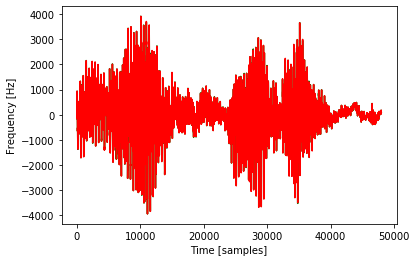

In [3]:
plt.plot(clean_sample_audio[96000:144000], color="green")
plt.plot(effected_sample_audio[96000:144000], color="red")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [samples]')
plt.show()

dry signal:


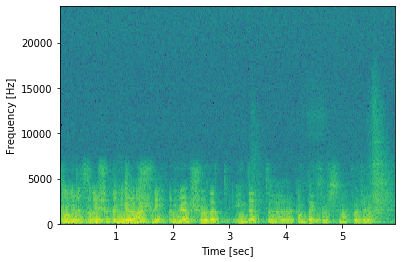

wet signal:


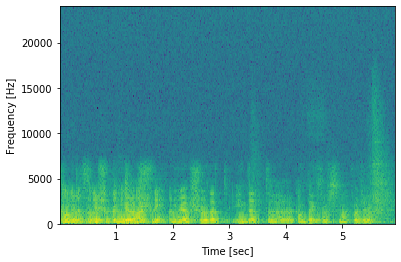

L2 distance: 3052.8052


In [4]:
def compute_distance(audio_1, audio_2):
    f_1, t_1, spec_1 = scipy.signal.spectrogram(audio_1, fs=48000)
    f_2, t_2, spec_2 = scipy.signal.spectrogram(audio_2, fs=48000)
    return np.linalg.norm(spec_1[:-1] - spec_2[:-1])

def display_spec(audio, label):
    f, t, spec = scipy.signal.spectrogram(audio, fs=48000)
    print(label, ":")
    plt.pcolormesh(t, f, np.log(spec))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    

f_dry, t_dry, spec_dry = scipy.signal.spectrogram(clean_sample_audio, fs=48000)
f_wet, t_wet, spec_wet = scipy.signal.spectrogram(effected_sample_audio, fs=48000)

print("dry signal:")
plt.pcolormesh(t_dry, f_dry, np.log(spec_dry))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print("wet signal:")
plt.pcolormesh(t_wet, f_wet, np.log(spec_wet))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#plt.plot(spec_dry, color="green")
#plt.plot(spec_wet, color="red")
#plt.show()

distance = np.linalg.norm(spec_dry[:-1] - spec_wet[:-1])
print("L2 distance:", distance)

initial distance 244.56041
iteration 0
NEW best distance of 37.95094 with gain of 11.12
NEW best distance of 26.488283 with gain of 10.67
NEW best distance of 14.719238 with gain of 9.87
NEW best distance of 14.336122 with gain of 10.1
NEW best distance of 14.087631 with gain of 9.969999999999999
NEW best distance of 13.275222 with gain of 10.049999999999999
iteration 100
iteration 200
iteration 300
NEW best distance of 13.208388 with gain of 10.03
iteration 400


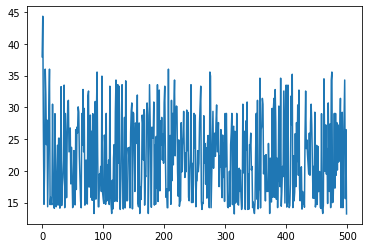

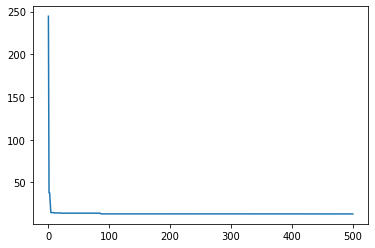

In [14]:
#stochastic hill-climbing function which changes EQ values
def apply_random_effect(source_audio, input_gain):
    
    #r_freq = np.random.randint(0, 24000)
    
    r_freq = 1000
    
    #r_width = np.random.randint(0, 2000)
    
    r_width = 100
    
    #r_gain = np.random.randint(-24, 24)
    
    r_gain = input_gain + (np.random.randint(-100, 100) / 100)
    
    x = np.round(source_audio).astype('int16')
    effected_audio = None
    try:
        #define graph
        process_audio = (ffmpeg
            .input('pipe:', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
            .filter("equalizer", f=r_freq, t='q', w=r_width, g=r_gain)
            .output('pipe:', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
            .run_async(pipe_stdin=True, pipe_stdout=True)
        )
        
        #pipe in the audio
        process_audio.stdin.write(
            source_audio
            .astype(np.int16)
            .tobytes()
        )
        process_audio.stdin.close()
        
        signal = process_audio.stdout.read()
        effected_audio = np.fromstring(signal, dtype=np.int16).astype(np.float16)
        process_audio.stdout.close()
        
    except ffmpeg.Error as e:
        print(e.stderr)
        sys.exit(1)
    return effected_audio, r_gain

def stochastic_hill_climb(source_audio, target_audio, iterations):
    #compute the distance between both files
    best_distance = compute_distance(source_audio, target_audio)
    print("initial distance", best_distance)
    best_audio = source_audio
    best_gain = 12
    guess_distances = []
    results = []
    
    results += [best_distance]
    for i in range(iterations):
        if (i % 100 == 0):
            print("iteration", i)
        #create a randomly effected candidate audio file (as float)
        new_audio, new_gain = apply_random_effect(source_audio, best_gain)
        #find the distance between both samples
        new_distance = compute_distance(new_audio, target_audio)
        guess_distances += [new_distance]
        #print(new_distance)
        if new_distance < best_distance:
            print("NEW best distance of", new_distance, "with gain of", new_gain)
            best_distance = new_distance
            best_audio = new_audio
            best_gain = new_gain
        results += [best_distance]
    return best_audio, guess_distances, results

best_audio, guess_distances, results  = stochastic_hill_climb(clean_sample_audio[96000:144000], 
                      effected_sample_audio[96000:144000],
                      500)
plt.plot(guess_distances)
plt.show()
plt.plot(results)
plt.show()

source audio :


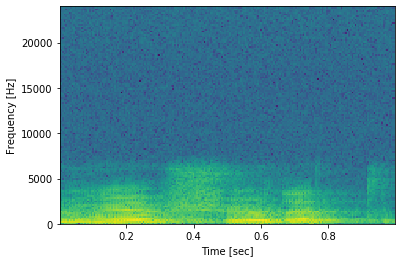

target audio :


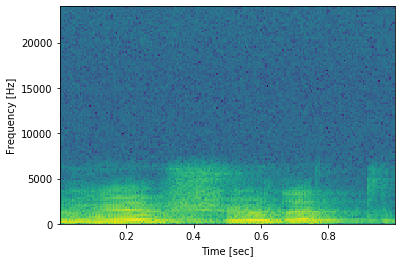

best audio :


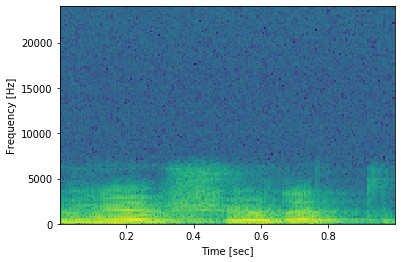

In [8]:
display_spec(clean_sample_audio[96000:144000], "source audio")
display_spec(effected_sample_audio[96000:144000], "target audio")
display_spec(best_audio, "best audio")

In [9]:
compute_distance(clean_sample_audio[96000:144000], 
                      effected_sample_audio[96000:144000])

244.56041

In [10]:
compute_distance(best_audio,effected_sample_audio[96000:144000])

13.208388